Epoch 1/50
8/8 [==============================] - 2s 39ms/step - loss: 0.6900 - accuracy: 0.5738 - val_loss: 0.6850 - val_accuracy: 0.7000
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.6808 - accuracy: 0.6878 - val_loss: 0.6709 - val_accuracy: 0.7000
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6635 - accuracy: 0.7173 - val_loss: 0.6432 - val_accuracy: 0.7000
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6309 - accuracy: 0.7384 - val_loss: 0.6036 - val_accuracy: 0.7167
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6051 - accuracy: 0.7468 - val_loss: 0.5479 - val_accuracy: 0.7167
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5601 - accuracy: 0.7384 - val_loss: 0.5065 - val_accuracy: 0.7667
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.5168 - accuracy: 0.7511 - val_loss: 0.4907 - val_accuracy: 0.7833
Epoch 8/50
8/8 [================

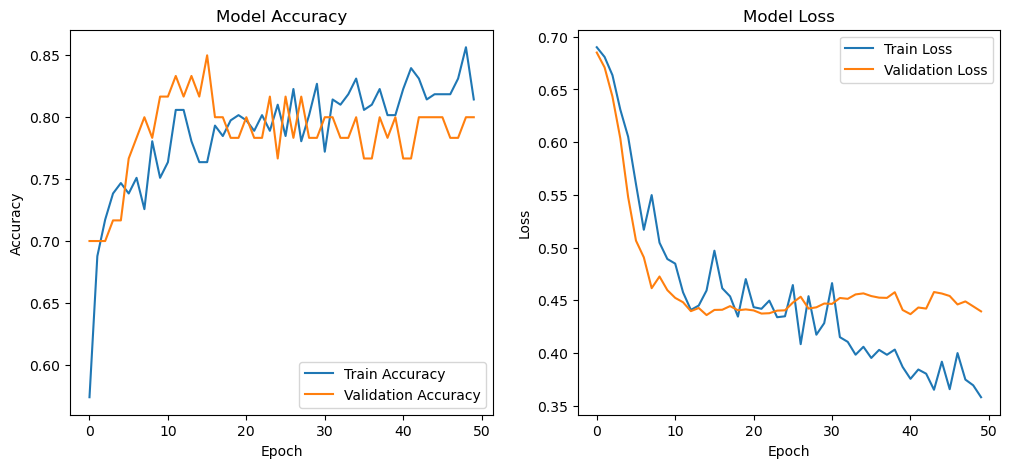

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load and preprocess the dataset
def load_and_preprocess_data(file_path):
    # Assuming the dataset has columns similar to the Cleveland dataset
    column_names = [
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
    ]
    data = pd.read_csv(file_path, header=None, names=column_names)
    data = data.dropna()  # Drop missing values

    # Convert target to binary (0 = no disease, 1 = disease)
    data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)
    
    # Split features and target
    X = data.drop('target', axis=1).values
    y = data['target'].values

    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for CNN input

    return X, y

# Load data
file_path = 'cleveland.csv'  # Replace with the actual path to your dataset
X, y = load_and_preprocess_data(file_path)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN-LSTM model
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    
    # CNN layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    # Pass directly to LSTM without flattening
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.4))
    
    # Dense output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train the model
model = build_cnn_lstm_model((X_train.shape[1], 1))
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions and evaluate performance
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot accuracy and loss curves
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_accuracy_loss(history)
